In [71]:
import antiCPy
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [72]:
XAI = np.load("XAI_Finance.npy")
Names = np.load("Names.npy")
CorrMatrices = np.load("CorrMatricesTriangular.npy")
LabelNaiveOrdered = np.load("LabelNaiveOrdered.npy")
#OptimalXAI = np.load("OptimalXAIFeature.npy")
# now something different
OptimalXAI = np.load("XAI_modes.npy")
OptimalXAI

array([[ 0, 47],
       [ 1, 37],
       [ 2,  8],
       [ 3, 43],
       [ 4, 45],
       [ 5, 43],
       [ 6,  8]])

In [73]:
clf = RandomForestClassifier(max_depth=20, random_state=0)

In [74]:
# 1 vs. all other clusters
print(OptimalXAI[0,:])

Label0 = (LabelNaiveOrdered == OptimalXAI[0,0])*1
print(Label0)

Data_0opt = CorrMatrices[:,OptimalXAI[0,1]]
Data_0opt = Data_0opt.reshape(-1,1)

# transform the imbalanced Data set
oversample = SMOTE()
Data_0opt, Label0 = oversample.fit_resample(Data_0opt, Label0)

X_train, X_test, y_train, y_test = train_test_split(Data_0opt, Label0,
                                                    test_size=0.5, random_state=1)
#X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.mean(), X_test.mean(), y_train.mean(), y_test.mean())

[ 0 47]
[1 1 0 ... 0 0 0]
0.375989458190872 0.3813329962535151 0.5062355658198614 0.49376443418013855


In [75]:
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print(np.mean(y_hat))
np.mean(y_hat == y_test )

0.5510392609699769


0.7496535796766743

Optimal feature is 47


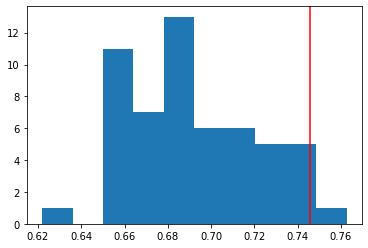

Optimal feature is 37


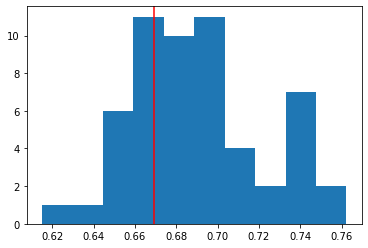

Optimal feature is 8


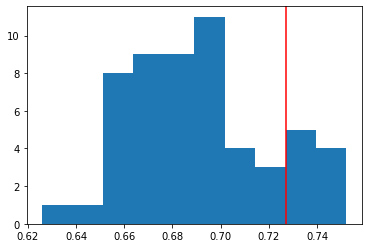

Optimal feature is 43


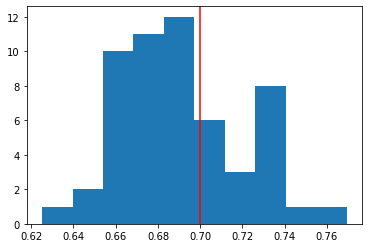

Optimal feature is 45


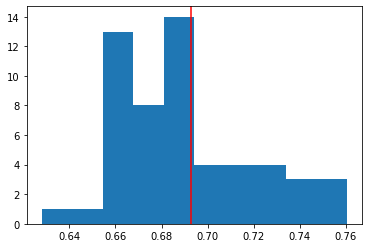

Optimal feature is 43


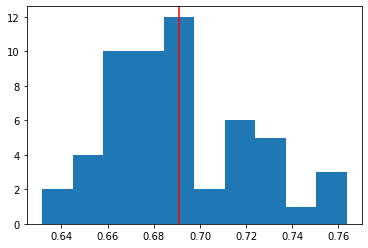

Optimal feature is 8


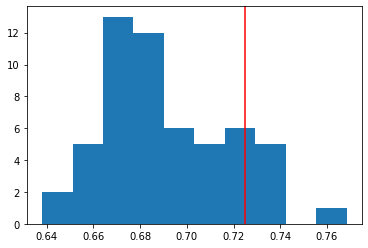

In [76]:
oversample = SMOTE()
for j in range(OptimalXAI.shape[0]):
    Scores = list()
    print("Optimal feature is", OptimalXAI[j,1])
    for i in range(CorrMatrices.shape[1]):
        Label0 = (LabelNaiveOrdered == OptimalXAI[0,0])*1
        Data_0 = CorrMatrices[:,i].reshape(-1,1)
        Data_0, Label0 = oversample.fit_resample(Data_0, Label0)
        X_train, X_test, y_train, y_test = train_test_split(Data_0, Label0,
                                                    test_size=0.5, random_state=1)
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        Scores.append( np.mean(y_hat == y_test ))
    plt.hist(Scores)
    plt.axvline(Scores[OptimalXAI[j,1]],c="red")
    plt.show()

### Train NN with all relevant features

For this, we need one-hot encoded y

In [77]:
print(set(OptimalXAI[:,1]))
CM_Reduced = CorrMatrices[:,list(set(OptimalXAI[:,1]))]
print(CM_Reduced.shape)

# one hot encoded
encoded_Y = np_utils.to_categorical(LabelNaiveOrdered)

X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
print(encoded_Y)

# reverse the encoding via
# np.argmax(encoded_Y, 1)

{37, 8, 43, 45, 47}
(5251, 5)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


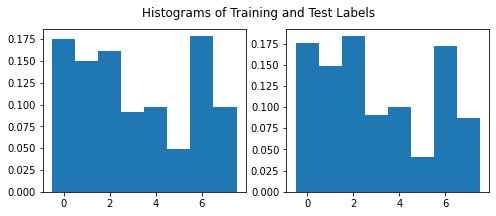

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(np.argmax(y_train,1), density = True,
         bins = np.arange(-0.5, max(np.argmax(y_train,1))+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Training and Test Labels")
plt.show()

In [79]:
n_In = CM_Reduced.shape[1]
num_classes = len(set(LabelNaiveOrdered))
print(n_In, num_classes)

model = keras.Sequential(
    [
        layers.Dense(units = 256, input_shape=(n_In,), activation = "selu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=1024,
              activation=keras.layers.LeakyReLU(alpha=0.05)),
        layers.Dense(units=128,
              activation=keras.layers.LeakyReLU(alpha=0.01)),
        layers.Dropout(0.3),
        layers.Dense(units =num_classes, activation="softmax"),
    ]
)
#model.build(n_In)
model.summary()

5 8
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 256)               1536      
                                                                 
 dense_37 (Dense)            (None, 128)               32896     
                                                                 
 dense_38 (Dense)            (None, 128)               16512     
                                                                 
 dense_39 (Dense)            (None, 1024)              132096    
                                                                 
 dense_40 (Dense)            (None, 128)               131200    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 8)            

In [80]:
batch_size = 128
epochs = 100

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

Epoch 1/100
14/14 [==============================] - 0s 15ms/step - loss: 2.0590 - accuracy: 0.1831 - val_loss: 2.0286 - val_accuracy: 0.2058
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 2.0011 - accuracy: 0.2177 - val_loss: 1.9702 - val_accuracy: 0.1995
Epoch 3/100
14/14 [==============================] - 0s 6ms/step - loss: 1.9386 - accuracy: 0.2211 - val_loss: 1.9008 - val_accuracy: 0.2103
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 1.8691 - accuracy: 0.2382 - val_loss: 1.8152 - val_accuracy: 0.2723
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 1.7801 - accuracy: 0.3081 - val_loss: 1.7214 - val_accuracy: 0.3354
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 1.6793 - accuracy: 0.3775 - val_loss: 1.6119 - val_accuracy: 0.3764
Epoch 7/100
14/14 [==============================] - 0s 6ms/step - loss: 1.5779 - accuracy: 0.4002 - val_loss: 1.4998 - val_accuracy: 0.4213
Epoch 8/100


In [81]:
y_hat = np.argmax(model.predict(X_test),1)
Accuracy_BestXAI = np.mean(y_hat == np.argmax(y_test,1))
print(Accuracy_BestXAI)

0.7974610502019619


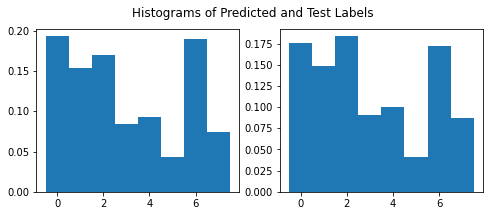

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(y_hat, density = True,
         bins = np.arange(-0.5, max(y_hat)+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Predicted and Test Labels")
plt.show()

### Now with some other features

In [83]:
def TestNN(seed = 1234):
    np.random.seed(seed)
    Index = np.random.choice(np.arange(XAI.shape[1]).astype("int"), # features to compare optimal XAI to
                     size = len(list(set(OptimalXAI[:,1]))),
                     replace = False)
    CM_Reduced = CorrMatrices[:,Index]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [84]:
TestNN(54321)

0.7380265435660704

In [85]:
TestNN()

0.7224466243508367

In [88]:
Runs = 100
NN_comparison = np.zeros(Runs)

for i in range(Runs):
    s = np.random.choice(np.arange(10000).astype("int"),1)
    Test_Score = TestNN(s)
    print(i,s,Test_Score)
    NN_comparison[i] = Test_Score


0 [400] 0.8395845354875938
1 [4242] 0.7611079053664166
2 [362] 0.7391806116560877
3 [7131] 0.743796884016157
4 [5389] 0.8188113098672821
5 [5094] 0.7749567224466244
6 [3484] 0.8222735141373341
7 [5208] 0.7409117137911136
8 [8855] 0.8263127524523947
9 [9349] 0.7634160415464513
10 [3280] 0.778995960761685
11 [1327] 0.7876514714368148
12 [9953] 0.7397576457010964
13 [6860] 0.7143681477207156
14 [893] 0.7847663012117715
15 [8554] 0.6468551644547028
16 [8382] 0.7253317945758799
17 [5396] 0.8528563185227929
18 [7369] 0.7212925562608193
19 [9226] 0.7847663012117715
20 [8924] 0.7114829774956722
21 [4485] 0.7166762839007501
22 [748] 0.7247547605308713
23 [3383] 0.8470859780727062
24 [9774] 0.7397576457010964
25 [5309] 0.7668782458165032
26 [1195] 0.7132140796306982
27 [1113] 0.7836122331217542
28 [5662] 0.7841892671667628
29 [6980] 0.6445470282746683
30 [7152] 0.8015002885170225
31 [5453] 0.676860934795153
32 [6669] 0.6889786497403346
33 [772] 0.753606462781304
34 [96] 0.7195614541257934
35 [76

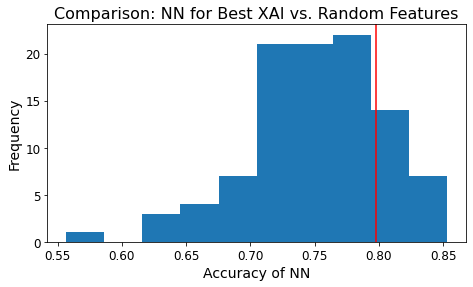

In [97]:
fig = plt.gcf()
fig.set_size_inches(7.5,4)
plt.hist(NN_comparison)
plt.axvline(Accuracy_BestXAI,
            c="red")
plt.xlabel("Accuracy of NN",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.title("Comparison: NN for Best XAI vs. Random Features",
          fontsize = 16)
plt.savefig("Comparison_RandomFeatures_vs_XAImode_100NN",dpi=600)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()